<a href="https://colab.research.google.com/github/manojkumar010/assignment/blob/main/assignment3code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3

## PART 1

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

tf.random.set_seed(42)

In [2]:
# 1. Loading the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Normalizing the images
x_train = x_train.astype('float32') / 255.0  # shape: (60000, 28, 28)
x_test = x_test.astype('float32') / 255.0

In [4]:
# Expanding dimensions for channel
x_train = np.expand_dims(x_train, -1)  # shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)

Train shape: (60000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


In [5]:
# 2. Tokenization mechanism
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Use a Conv2D layer to extract patches and project to embed_dim
        self.projection = layers.Conv2D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding='VALID'
        )

    def call(self, images):
        x = self.projection(images)  # (batch_size, new_h, new_w, embed_dim)
        patches = tf.reshape(x, [tf.shape(x)[0], -1, self.embed_dim])
        return patches


In [6]:
# 3. Learnable positional encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_emb = self.add_weight(
            name="pos_embedding",
            shape=[1, num_patches, embed_dim],
            initializer="random_normal",
        )

    def call(self, x):
        return x + self.pos_emb


In [7]:

# 4. Implementing Multi-Head Attention from scratch
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.depth = embed_dim // num_heads

        self.Wq = layers.Dense(embed_dim)
        self.Wk = layers.Dense(embed_dim)
        self.Wv = layers.Dense(embed_dim)
        self.dense = layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    def call(self, x):
        batch_size = tf.shape(x)[0]

        q = self.Wq(x)  # (batch_size, seq_len, embed_dim)
        k = self.Wk(x)
        v = self.Wv(x)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled Dot-Product Attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len, seq_len)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (batch_size, num_heads, seq_len, seq_len)

        output = tf.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, depth)
        output = tf.transpose(output, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)
        concat_attention = tf.reshape(output, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)

        out = self.dense(concat_attention)
        return out

In [8]:
# 5. Encoder Block
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.mha = MultiHeadSelfAttention(embed_dim, num_heads)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)

        self.ffn = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.dropout2 = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, training):
        attn_output = self.mha(x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)



In [9]:
# 6. Build the full Transformer model
class VisionTransformer(tf.keras.Model):
    def __init__(self, patch_size, embed_dim, num_heads, mlp_dim, num_layers, num_classes):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.patch_embed = PatchEmbedding(patch_size, embed_dim)  # Instantiating PatchEmbedding layer here
        self.pos_embed = self.add_weight(
            name="pos_embed",
            shape=(1, (28 // patch_size)*(28 // patch_size), embed_dim),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
            trainable=True
        )

        self.encoders = [
            TransformerEncoder(embed_dim, num_heads, mlp_dim)
            for _ in range(num_layers)
        ]

        self.mlp_head = tf.keras.layers.Dense(num_classes)

    def call(self, x, training=False):
        # Tokenization (using the already instantiated PatchEmbedding layer)
        x = self.patch_embed(x)  # Calling the already instantiated PatchEmbedding layer
        # Add positional embedding
        x += self.pos_embed
        # Pass through encoder layers
        for encoder in self.encoders:
            x = encoder(x, training=training)
        # Take mean across tokens
        x = tf.reduce_mean(x, axis=1)
        # Final prediction
        x = self.mlp_head(x)
        return x


In [10]:
# Instantiate and compile the model
patch_size = 7  # 28x28 -> 4x4 = 16 patches
embed_dim = 64
num_heads = 4
mlp_dim = 128
num_layers = 4
num_classes = 10

model = VisionTransformer(patch_size, embed_dim, num_heads, mlp_dim, num_layers, num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [11]:
# 7. Training the model
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, y_test)
)



Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.6295 - loss: 1.0844 - val_accuracy: 0.9538 - val_loss: 0.1498
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9454 - loss: 0.1774 - val_accuracy: 0.9634 - val_loss: 0.1182
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9627 - loss: 0.1234 - val_accuracy: 0.9715 - val_loss: 0.0896
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9665 - loss: 0.1072 - val_accuracy: 0.9710 - val_loss: 0.0905
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9713 - loss: 0.0926 - val_accuracy: 0.9659 - val_loss: 0.1068
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9732 - loss: 0.0858 - val_accuracy: 0.9767 - val_loss: 0.0725
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9771 - loss: 0.0726 - val_accuracy: 0.9779 - val_loss: 0.0742
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9782 - loss: 0.0700 - val_accuracy: 

In [12]:
# Evaluating on test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9788 - loss: 0.0775
Test accuracy: 0.9828


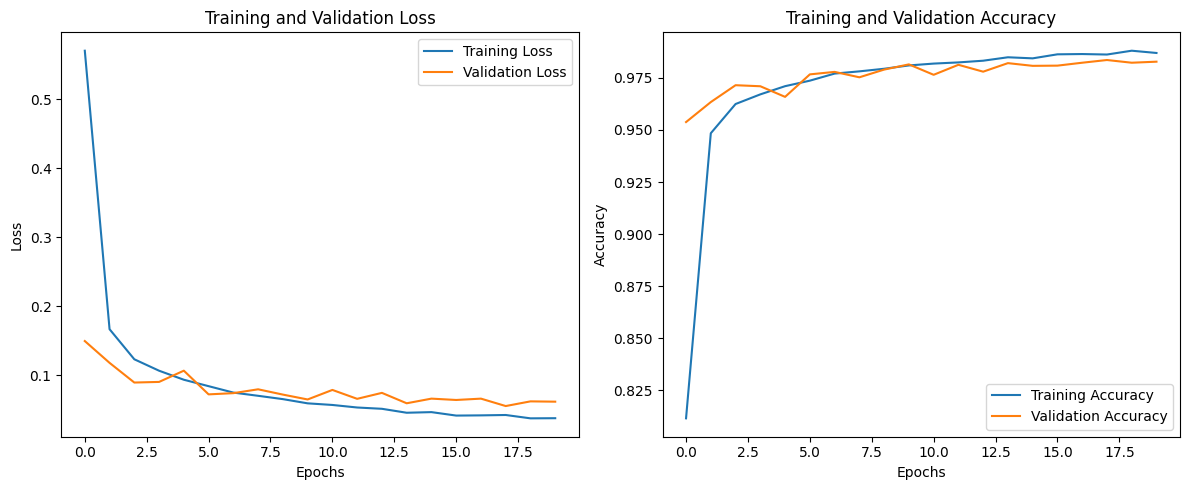

In [13]:
import matplotlib.pyplot as plt

# Assuming `history` is the history object returned by model.fit()
# Plotting Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


## PART 2

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
import math

In [12]:


class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x


In [13]:


class EfficientAttention(nn.Module):
    def __init__(self, dim, heads=8, proj_k=64):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.proj_k = proj_k

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        # Linear projection for keys and values
        self.E = nn.Parameter(torch.randn(proj_k, dim // heads))
        self.F = nn.Parameter(torch.randn(proj_k, dim // heads))

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).chunk(3, dim=-1)  # (B, N, D) each
        q, k, v = [t.view(B, N, self.heads, D // self.heads).transpose(1, 2) for t in qkv]

        # Project keys and values to lower dimension using E, F
        k_proj = torch.einsum("bhnd,md->bhnm", k, self.E)  # (B, h, N, proj_k)
        v_proj = torch.einsum("bhnd,md->bhnm", v, self.F)  # (B, h, N, proj_k)

        attn = torch.einsum("bhnd,bhnm->bhdm", q, k_proj) * self.scale
        attn = attn.softmax(dim=-1)
        out = torch.einsum("bhdm,bhnm->bhnd", attn, v_proj)

        out = out.transpose(1, 2).reshape(B, N, D)
        return self.proj(out)


In [14]:
class EfficientTransformerEncoder(nn.Module):
    def __init__(self, dim, heads=8, proj_k=64, mlp_dim=256, dropout=0.1):
        super().__init__()
        self.attn = EfficientAttention(dim, heads=heads, proj_k=proj_k)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [15]:
class EfficientVisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, num_classes=10,
                 embed_dim=128, depth=6, heads=8, proj_k=64, mlp_dim=256, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.encoder_layers = nn.ModuleList([
            EfficientTransformerEncoder(embed_dim, heads, proj_k, mlp_dim, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        batch_size = x.size(0)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed
        x = self.dropout(x)

        for layer in self.encoder_layers:
            x = layer(x)

        x = self.norm(x)
        cls_output = x[:, 0]
        return self.mlp_head(cls_output)


In [19]:

# Hyperparameters
img_size = 28
patch_size = 7
embed_dim = 256
num_heads = 8
num_layers = 6
num_classes = 10

# Defining transformations for your data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the datasets
train_dataset = datasets.MNIST(
    root='./data',  # Where to download or find your data
    train=True,
    download=True,
    transform=train_transform
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

# Creating the DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,  # Adjust batch size as needed
    shuffle=True  # Shuffle the training data in each epoch
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False  # No need to shuffle test data
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.44MB/s]


In [22]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    acc = 100 * correct / total
    return avg_loss, acc

In [24]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    acc = 100 * correct / total
    return avg_loss, acc

In [25]:
# Initializing Efficient Transformer model (Part-2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_efficient = EfficientVisionTransformer().to(device)
optimizer_efficient = torch.optim.Adam(model_efficient.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()
train_losses_efficient = []
test_acc_efficient = []

epochs = 10
for epoch in range(epochs):
    loss_e, acc_e = train_model(model_efficient, train_loader, criterion, optimizer_efficient, device)
    test_loss_e, test_acc_e = evaluate_model(model_efficient, test_loader, criterion, device)

    train_losses_efficient.append(loss_e)
    test_acc_efficient.append(test_acc_e)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Efficient Attention -> Train Loss: {loss_e:.4f}, Train Accuracy: {acc_e:.2f}%, Test Accuracy: {test_acc_e:.2f}%")


Epoch 1/10
Efficient Attention -> Train Loss: 0.6739, Train Accuracy: 77.42%, Test Accuracy: 91.43%
Epoch 2/10
Efficient Attention -> Train Loss: 0.2476, Train Accuracy: 92.30%, Test Accuracy: 93.95%
Epoch 3/10
Efficient Attention -> Train Loss: 0.1890, Train Accuracy: 94.11%, Test Accuracy: 95.15%
Epoch 4/10
Efficient Attention -> Train Loss: 0.1654, Train Accuracy: 94.75%, Test Accuracy: 95.54%
Epoch 5/10
Efficient Attention -> Train Loss: 0.1439, Train Accuracy: 95.48%, Test Accuracy: 95.79%
Epoch 6/10
Efficient Attention -> Train Loss: 0.1402, Train Accuracy: 95.64%, Test Accuracy: 96.28%
Epoch 7/10
Efficient Attention -> Train Loss: 0.1265, Train Accuracy: 95.95%, Test Accuracy: 96.37%
Epoch 8/10
Efficient Attention -> Train Loss: 0.1174, Train Accuracy: 96.26%, Test Accuracy: 96.31%
Epoch 9/10
Efficient Attention -> Train Loss: 0.1098, Train Accuracy: 96.48%, Test Accuracy: 96.59%
Epoch 10/10
Efficient Attention -> Train Loss: 0.1085, Train Accuracy: 96.53%, Test Accuracy: 96.51%

In [1]:
# Function to plot attention maps
def plot_attention_map(attention_weights, layer_num=0, head_num=0):
    attention_map = attention_weights[layer_num, head_num].detach().cpu().numpy()
    plt.imshow(attention_map, cmap='viridis')
    plt.colorbar()
    plt.title(f"Attention Map - Layer {layer_num}, Head {head_num}")
    plt.show()



# PART 3

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
import math

In [60]:
class MultiScalePatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_sizes=[7, 4], embed_dim=256):
        super(MultiScalePatchEmbedding, self).__init__()
        self.embedders = nn.ModuleList([
            nn.Conv2d(1, embed_dim, kernel_size=p, stride=p)
            for p in patch_sizes
        ])
        self.total_dim = embed_dim * len(patch_sizes)  # Store total dimension

    def forward(self, x):
        patch_embeddings = []
        for embedder in self.embedders:
            patches = embedder(x)
            patches = patches.flatten(2).transpose(1, 2)
            patch_embeddings.append(patches)

        x = torch.cat(patch_embeddings, dim=1)
        return x # The total embedding dimension is now embed_dim * len(patch_sizes)

In [61]:
class MultiScaleVisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_sizes=[7, 4], embed_dim=256, num_heads=8, num_layers=6, num_classes=10):
        super(MultiScaleVisionTransformer, self).__init__()
        self.patch_embed = MultiScalePatchEmbedding(img_size, patch_sizes, embed_dim)

        # Get the total embedding dimension from the patch embedding layer
        example_input = torch.randn(1, 1, img_size, img_size)
        self.embed_dim = self.patch_embed(example_input).shape[-1]  # Get embed_dim from patch_embed

        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))  # Use the correct embed_dim here
        num_patches = self.patch_embed(example_input).shape[1]
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))  # Use the correct embed_dim here
        self.pos_drop = nn.Dropout(0.0)

        self.blocks = nn.ModuleList([
            MultiScaleTransformerBlock(self.embed_dim, num_heads)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(self.embed_dim)  # Use the correct embed_dim here
        self.head = nn.Linear(self.embed_dim, num_classes)  # Use the correct embed_dim here

    def forward(self, x):
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)

        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + num_patches, embed_dim)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        attention_maps = []
        for block in self.blocks:
            x, attn_map = block(x)
            attention_maps.append(attn_map)

        x = self.norm(x)
        return self.head(x[:, 0]), attention_maps

In [53]:
class MultiScaleAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiScaleAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)  # (3, B, heads, N, head_dim)

        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_probs = attn_scores.softmax(dim=-1)
        out = (attn_probs @ v).transpose(1, 2).reshape(B, N, C)

        out = self.out_proj(out)
        return out, attn_probs


In [54]:
class MultiScaleTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiScaleTransformerBlock, self).__init__()
        self.attention = MultiScaleAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x):
        attn_out, attn_map = self.attention(x)
        x = self.norm1(x + attn_out)
        mlp_out = self.mlp(x)
        x = self.norm2(x + mlp_out)
        return x, attn_map


In [56]:

# Hyperparameters
img_size = 28
patch_size = 7
embed_dim = 256
num_heads = 8
num_layers = 6
num_classes = 10

# Defining transformations for your data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the datasets
train_dataset = datasets.MNIST(
    root='./data',  # Where to download or find your data
    train=True,
    download=True,
    transform=train_transform
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

# Creating the DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,  # Adjusting batch size
    shuffle=True  # Shuffle the training data in each epoch
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False  # No need to shuffle test data
)

In [63]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Unpack the tuple to get the model's output
        outputs, _ = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    acc = 100 * correct / total
    return avg_loss, acc



In [65]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            # Get the model's output (logits) and attention maps
            outputs, _ = model(images)
            # Use only the logits for calculating the loss
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    acc = 100 * correct / total
    return avg_loss, acc

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_multiscale = MultiScaleVisionTransformer().to(device)
optimizer_multiscale = torch.optim.Adam(model_multiscale.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_losses_multiscale = []
test_acc_multiscale = []

epochs = 10

for epoch in range(epochs):
    loss_m, acc_m = train_model(model_multiscale, train_loader, criterion, optimizer_multiscale, device)
    test_loss_m, test_acc_m = evaluate_model(model_multiscale, test_loader, criterion, device)

    train_losses_multiscale.append(loss_m)
    test_acc_multiscale.append(test_acc_m)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Multi-Scale Attention -> Train Loss: {loss_m:.4f}, Test Accuracy: {test_acc_m:.2f}%")


Epoch 1/10
Multi-Scale Attention -> Train Loss: 2.3272, Test Accuracy: 10.10%
Epoch 2/10
Multi-Scale Attention -> Train Loss: 2.3103, Test Accuracy: 11.35%
Epoch 3/10
Multi-Scale Attention -> Train Loss: 2.3078, Test Accuracy: 10.09%
Epoch 4/10
Multi-Scale Attention -> Train Loss: 2.3048, Test Accuracy: 9.80%
Epoch 5/10
Multi-Scale Attention -> Train Loss: 2.3033, Test Accuracy: 9.74%
Epoch 6/10
Multi-Scale Attention -> Train Loss: 2.3031, Test Accuracy: 11.35%
Epoch 7/10
Multi-Scale Attention -> Train Loss: 2.3024, Test Accuracy: 11.35%
Epoch 8/10
Multi-Scale Attention -> Train Loss: 2.3021, Test Accuracy: 11.35%
Epoch 9/10
Multi-Scale Attention -> Train Loss: 2.3020, Test Accuracy: 11.35%
Epoch 10/10
Multi-Scale Attention -> Train Loss: 2.3018, Test Accuracy: 11.35%
